# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

## Import modules

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.metrics import confusion_matrix
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys


In [39]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
ls '/content/gdrive/My Drive/DLProj/'

 data/  'DeepLearningProject - Chandrabose111.ipynb'


In [0]:

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [0]:
reset_graph()
img_size = 32
img_shape = (img_size, img_size)
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=300 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

## Reading the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


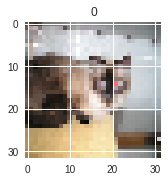

In [43]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            image = cv2.imread(img)
            im_resize = cv2.resize(image,(img_shape), interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train = read_images_classes('/content/gdrive/My Drive/DLProj/data/train')
X_test, y_test = read_images_classes('/content/gdrive/My Drive/DLProj/data/test')

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)
fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(32,32), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

In [44]:
X_train.reshape(-1,32,32,3)

array([[[[ 86,  90,  91],
         [ 40,  61,  83],
         [ 42,  50,  59],
         ...,
         [110, 112, 106],
         [102, 104,  98],
         [ 93,  93,  87]],

        [[ 87,  90,  94],
         [152, 159, 184],
         [184, 174, 196],
         ...,
         [119, 119, 113],
         [112, 112, 106],
         [103, 103,  97]],

        [[142, 140, 139],
         [142, 141, 146],
         [142, 141, 154],
         ...,
         [128, 128, 122],
         [122, 122, 116],
         [111, 111, 105]],

        ...,

        [[ 96, 148, 178],
         [100, 153, 180],
         [108, 163, 194],
         ...,
         [ 66,  73,  74],
         [ 58,  66,  65],
         [ 47,  58,  62]],

        [[ 85, 135, 165],
         [ 94, 144, 171],
         [ 99, 154, 185],
         ...,
         [128, 129, 125],
         [117, 116, 106],
         [ 56,  63,  65]],

        [[ 79, 129, 156],
         [ 80, 134, 169],
         [ 85, 136, 169],
         ...,
         [130, 129, 125],
        

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

##Defining the Layers

In [0]:
from tensorflow import keras
x = tf.placeholder(dtype=tf.float64, shape=[None, 32, 32, 3])
keep_prob = tf.placeholder(tf.float32)
c1 = tf.layers.conv2d(inputs=x, activation=tf.nn.relu, filters=64, kernel_size=[5,5], padding='VALID', strides=1) #input to c1 is x
p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[2,2], strides=2) #input to p1 is c1

c2 = tf.layers.conv2d(inputs=p1, activation=tf.nn.relu, filters=32, kernel_size=[5,5], padding='VALID', strides=1) #input to c2 is p1
p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[2,2], strides=2) #input to p2 is c2
    
f = tf.contrib.layers.flatten(p2) 
 
fc1 = tf.layers.dense(inputs=f, units=32, activation=tf.nn.relu)
drop_out = tf.nn.dropout(fc1, rate=0.4)
logits = tf.layers.dense(inputs = drop_out, units=2)  

###Calculating Loss and Accuracy of The Model

In [0]:
y = tf.placeholder(dtype=tf.int64)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits) # No need of onehot encodings

correct_prediction = tf.equal(tf.argmax(logits, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optim = tf.train.AdamOptimizer(learning_rate=0.001)
trainer = optim.minimize(loss)

###Training for 100 epochs/iterations :

In [48]:
epochs = 100
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epochs):
    sess.run([trainer], feed_dict={x:X_train/255., y:y_train, keep_prob:0.6})
    [acc, l] = sess.run([accuracy, loss], feed_dict={x:X_train/255., y:y_train, keep_prob:1})
    
    if i%5==0:
        print('Step %d - Loss: %.2f | Accuracy: %.2f'%(i,np.mean(l),acc))

Step 0 - Loss: 0.73 | Accuracy: 0.35
Step 5 - Loss: 0.68 | Accuracy: 0.62
Step 10 - Loss: 0.65 | Accuracy: 0.70
Step 15 - Loss: 0.59 | Accuracy: 0.65
Step 20 - Loss: 0.55 | Accuracy: 0.73
Step 25 - Loss: 0.50 | Accuracy: 0.75
Step 30 - Loss: 0.38 | Accuracy: 0.88
Step 35 - Loss: 0.34 | Accuracy: 0.88
Step 40 - Loss: 0.27 | Accuracy: 0.93
Step 45 - Loss: 0.21 | Accuracy: 0.98
Step 50 - Loss: 0.18 | Accuracy: 0.98
Step 55 - Loss: 0.17 | Accuracy: 0.95
Step 60 - Loss: 0.10 | Accuracy: 0.98
Step 65 - Loss: 0.07 | Accuracy: 0.98
Step 70 - Loss: 0.05 | Accuracy: 1.00
Step 75 - Loss: 0.03 | Accuracy: 1.00
Step 80 - Loss: 0.08 | Accuracy: 0.98
Step 85 - Loss: 0.02 | Accuracy: 1.00
Step 90 - Loss: 0.01 | Accuracy: 1.00
Step 95 - Loss: 0.03 | Accuracy: 1.00


In [49]:
# Evaluation & Final accuracy and loss for 100 iterations

[yh] = sess.run([logits], feed_dict={x:X_train, y:y_train, keep_prob:1})
pred_class_train = np.argmax(yh, axis=1)

[yh_val] = sess.run([logits], feed_dict={x:X_test, keep_prob:1})
pred_class_val = np.argmax(yh_val, axis=1)

cm_val = confusion_matrix(y_true=y_test, y_pred=pred_class_val)
acc_val = np.trace(cm_val)/np.sum(cm_val)
print(acc_val)

0.6


###Training for 200 epochs/iterations :

In [50]:
epochs = 200
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epochs):
    sess.run([trainer], feed_dict={x:X_train/255., y:y_train, keep_prob:0.6})
    [acc, l] = sess.run([accuracy, loss], feed_dict={x:X_train/255., y:y_train, keep_prob:1})
    
    if i%5==0:
        print('Step %d - Loss: %.2f | Accuracy: %.2f'%(i,np.mean(l),acc))

Step 0 - Loss: 0.73 | Accuracy: 0.35
Step 5 - Loss: 0.68 | Accuracy: 0.62
Step 10 - Loss: 0.65 | Accuracy: 0.70
Step 15 - Loss: 0.59 | Accuracy: 0.65
Step 20 - Loss: 0.55 | Accuracy: 0.73
Step 25 - Loss: 0.50 | Accuracy: 0.75
Step 30 - Loss: 0.38 | Accuracy: 0.88
Step 35 - Loss: 0.34 | Accuracy: 0.88
Step 40 - Loss: 0.27 | Accuracy: 0.93
Step 45 - Loss: 0.21 | Accuracy: 0.98
Step 50 - Loss: 0.18 | Accuracy: 0.98
Step 55 - Loss: 0.17 | Accuracy: 0.95
Step 60 - Loss: 0.10 | Accuracy: 0.98
Step 65 - Loss: 0.07 | Accuracy: 0.98
Step 70 - Loss: 0.05 | Accuracy: 1.00
Step 75 - Loss: 0.03 | Accuracy: 1.00
Step 80 - Loss: 0.08 | Accuracy: 0.98
Step 85 - Loss: 0.02 | Accuracy: 1.00
Step 90 - Loss: 0.01 | Accuracy: 1.00
Step 95 - Loss: 0.03 | Accuracy: 1.00
Step 100 - Loss: 0.01 | Accuracy: 1.00
Step 105 - Loss: 0.01 | Accuracy: 1.00
Step 110 - Loss: 0.01 | Accuracy: 1.00
Step 115 - Loss: 0.00 | Accuracy: 1.00
Step 120 - Loss: 0.00 | Accuracy: 1.00
Step 125 - Loss: 0.01 | Accuracy: 1.00
Step 130

In [51]:
# Evaluation & Final accuracy and loss for 200 iterations
    
[yh] = sess.run([logits], feed_dict={x:X_train, y:y_train, keep_prob:1})
pred_class_train = np.argmax(yh, axis=1)

[yh_val] = sess.run([logits], feed_dict={x:X_test, keep_prob:1})
pred_class_val = np.argmax(yh_val, axis=1)

cm_val = confusion_matrix(y_true=y_test, y_pred=pred_class_val)
acc_val = np.trace(cm_val)/np.sum(cm_val)
print(acc_val)

0.65


###Training for 300 epochs/iterations :

In [52]:
epochs = 300
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epochs):
    sess.run([trainer], feed_dict={x:X_train/255., y:y_train, keep_prob:0.6})
    [acc, l] = sess.run([accuracy, loss], feed_dict={x:X_train/255., y:y_train, keep_prob:1})
    
    if i%5==0:
        print('Step %d - Loss: %.2f | Accuracy: %.2f'%(i,np.mean(l),acc))

Step 0 - Loss: 0.73 | Accuracy: 0.35
Step 5 - Loss: 0.68 | Accuracy: 0.62
Step 10 - Loss: 0.65 | Accuracy: 0.70
Step 15 - Loss: 0.59 | Accuracy: 0.65
Step 20 - Loss: 0.55 | Accuracy: 0.73
Step 25 - Loss: 0.50 | Accuracy: 0.75
Step 30 - Loss: 0.38 | Accuracy: 0.88
Step 35 - Loss: 0.34 | Accuracy: 0.88
Step 40 - Loss: 0.27 | Accuracy: 0.93
Step 45 - Loss: 0.21 | Accuracy: 0.98
Step 50 - Loss: 0.18 | Accuracy: 0.98
Step 55 - Loss: 0.17 | Accuracy: 0.95
Step 60 - Loss: 0.10 | Accuracy: 0.98
Step 65 - Loss: 0.07 | Accuracy: 0.98
Step 70 - Loss: 0.05 | Accuracy: 1.00
Step 75 - Loss: 0.03 | Accuracy: 1.00
Step 80 - Loss: 0.08 | Accuracy: 0.98
Step 85 - Loss: 0.02 | Accuracy: 1.00
Step 90 - Loss: 0.01 | Accuracy: 1.00
Step 95 - Loss: 0.03 | Accuracy: 1.00
Step 100 - Loss: 0.01 | Accuracy: 1.00
Step 105 - Loss: 0.01 | Accuracy: 1.00
Step 110 - Loss: 0.01 | Accuracy: 1.00
Step 115 - Loss: 0.00 | Accuracy: 1.00
Step 120 - Loss: 0.00 | Accuracy: 1.00
Step 125 - Loss: 0.01 | Accuracy: 1.00
Step 130

In [53]:
# Evaluation & Final accuracy and loss for 300 iterations 

[yh] = sess.run([logits], feed_dict={x:X_train, y:y_train, keep_prob:1})
pred_class_train = np.argmax(yh, axis=1)

[yh_val] = sess.run([logits], feed_dict={x:X_test, keep_prob:1})
pred_class_val = np.argmax(yh_val, axis=1)

cm_val = confusion_matrix(y_true=y_test, y_pred=pred_class_val)
acc_val = np.trace(cm_val)/np.sum(cm_val)
print(acc_val)

0.6


#### ==============================================================